# 01 - Uber Rides ETL and Facebook Prophet

This notebook has 3 parts:  
1) Data cleaning  
2) Modeling using facebook prophet  
3) Comparison of different models (prophet vs. GRU)

In [1]:
import numpy as np
import pandas as pd
import pyflux as pf
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


## Data Cleaning

### Uber rides data

In [2]:
loc_ids = pd.read_csv("../s3/taxi-zone-lookup.csv")
uber = pd.read_csv("../s3/uber_rides.csv",index_col="index")
uber = uber.rename(columns={"locationID": "LocationID"})

In [3]:
merged = uber.merge(loc_ids,on="LocationID",how="left")
merged.Pickup_date = pd.to_datetime(merged.Pickup_date)
merged = merged.rename(columns={"Pickup_date":"date"})

In [4]:
merged_zone = merged.drop(["LocationID","Borough"],1)
# Round datetime to hourly
merged_zone = merged_zone.assign(date=merged_zone.date.dt.round('H'))
merged_zone.head(10)

,date,Zone
0,2015-05-17 10:00:00,Lenox Hill West
1,2015-05-17 10:00:00,Downtown Brooklyn/MetroTech
2,2015-05-17 10:00:00,Garment District
3,2015-05-17 10:00:00,East Williamsburg
4,2015-05-17 10:00:00,Flatiron
5,2015-05-17 10:00:00,Sunset Park West
6,2015-05-17 10:00:00,Astoria
7,2015-05-17 10:00:00,East Harlem North
8,2015-05-17 10:00:00,West Village
9,2015-05-17 10:00:00,Bensonhurst West


In [5]:
merged_zone.date.describe()

count                14270479
unique                   4337
top       2015-06-27 22:00:00
freq                    10959
first     2015-01-01 00:00:00
last      2015-07-01 00:00:00
Name: date, dtype: object

In [6]:
# hourly pickups for each location(zone)
merged_loc = merged_zone.pivot_table(index='date', columns='Zone', aggfunc=len, fill_value=0)
merged_loc.head()

Zone,Allerton/Pelham Gardens,Alphabet City,Arden Heights,Arrochar/Fort Wadsworth,Astoria,Astoria Park,Auburndale,Baisley Park,Bath Beach,Battery Park,...,Williamsbridge/Olinville,Williamsburg (North Side),Williamsburg (South Side),Windsor Terrace,Woodhaven,Woodlawn/Wakefield,Woodside,World Trade Center,Yorkville East,Yorkville West
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,1,25,0,0,24,0,1,0,5,0,...,0,41,42,2,2,1,6,8,23,31
2015-01-01 01:00:00,2,56,0,0,56,0,4,0,2,0,...,2,184,100,15,5,1,2,18,39,83
2015-01-01 02:00:00,1,46,0,1,34,2,1,0,1,1,...,1,183,85,7,9,2,4,8,27,51
2015-01-01 03:00:00,2,44,1,1,56,0,2,1,1,0,...,2,266,114,9,12,3,10,11,20,42
2015-01-01 04:00:00,2,41,0,0,47,1,0,1,1,0,...,2,204,122,8,7,1,11,15,19,28


In [10]:
# Dropping locations that have too many 0 rides per hour
# Assuming 12hr window, (181 days in the total timeframe) * 12 hours
df_zeros = (merged_loc == 0)
should_drop = []
for i in range(len(df_zeros.columns)):
    if df_zeros.iloc[:,i].sum() >2172:
        should_drop.append(df_zeros.columns[i])
len(should_drop)

64

In [11]:
#Somewhat arbitrary, but also dropping locations with less than 2 rides per hour on average
low_avg = (merged_loc.mean() < 2) 
for i in range(len(low_avg)):
    if low_avg[i]:
        if low_avg.index[i] not in should_drop:
            should_drop.append(low_avg.index[i])
len(should_drop)

120

In [12]:
# Drop low traffic locations and july 1st datapoint
rides = merged_loc.drop(should_drop,1)
rides = rides.iloc[:-1,:]

In [23]:
rides.tail()

Zone,Alphabet City,Astoria,Battery Park City,Bay Ridge,Bayside,Bedford,Belmont,Bensonhurst West,Bloomingdale,Boerum Hill,...,West Concourse,West Village,Williamsburg (North Side),Williamsburg (South Side),Windsor Terrace,Woodhaven,Woodside,World Trade Center,Yorkville East,Yorkville West
date,,,,,,,,,,,,,,,,,,,,,
2015-06-30 19:00:00,30,24,91,12,5,18,4,2,6,25,...,2,98,72,49,8,4,10,43,39,41
2015-06-30 20:00:00,20,42,77,7,5,18,2,6,3,28,...,8,81,64,61,10,4,6,42,34,34
2015-06-30 21:00:00,31,38,64,10,5,32,2,3,11,22,...,2,114,77,50,4,2,6,24,24,39
2015-06-30 22:00:00,33,29,87,14,5,25,1,3,5,31,...,1,131,89,58,6,2,9,34,25,38
2015-06-30 23:00:00,24,33,42,14,4,33,2,3,4,36,...,5,155,105,61,5,1,12,16,14,34


### Weather data

In [14]:
# Load Weather data for the station in NY central park
weather = pd.read_csv("../s3/2015weather.csv")[["DATE","HOURLYDRYBULBTEMPF","HOURLYPrecip"]]
weather = weather.rename(columns={"DATE":"date","HOURLYDRYBULBTEMPF":"temp","HOURLYPrecip":"precip"})
#convert to datetime and round up to hourly
weather.date = pd.to_datetime(weather.date)
weather = weather.assign(date=weather.date.dt.round('H'))
#Replace "T" (traces of rain) to 0.001, forwardfill nans
weather["precip"] = pd.to_numeric(weather.precip.str.strip().replace("T",0.001),errors="coerce")
weather.fillna(method='ffill',inplace=True)
# There are multiple random measurements per hour. So I'm just going to take their mean
weather_hourly = weather.groupby("date").agg("mean")
weather_hourly = weather_hourly.iloc[:-1,:]
weather_hourly.head()

,temp,precip
date,,
2015-01-01 01:00:00,28.0,0.0
2015-01-01 02:00:00,28.0,0.0
2015-01-01 03:00:00,27.0,0.0
2015-01-01 04:00:00,27.0,0.0
2015-01-01 05:00:00,27.0,0.0


In [22]:
weather_hourly.tail()

,temp,precip
date,,
2015-06-30 19:00:00,74.666667,0.0
2015-06-30 20:00:00,73.666667,0.0
2015-06-30 21:00:00,74.000000,0.0
2015-06-30 22:00:00,74.000000,0.0
2015-06-30 23:00:00,74.000000,0.0


### Merge the dataframes, and pickle for use

In [48]:
# merge weather and rides
rides_weather = rides.join(weather_hourly, how="right").fillna(method="bfill")

In [57]:
# Pickle rides & weather data 
rides_weather.to_pickle("rides_weather.pkl")

In [49]:
rides_weather.head()

,Alphabet City,Astoria,Battery Park City,Bay Ridge,Bayside,Bedford,Belmont,Bensonhurst West,Bloomingdale,Boerum Hill,...,Williamsburg (North Side),Williamsburg (South Side),Windsor Terrace,Woodhaven,Woodside,World Trade Center,Yorkville East,Yorkville West,temp,precip
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 01:00:00,56.0,56.0,29.0,18.0,3.0,48.0,3.0,5.0,12.0,52.0,...,184.0,100.0,15.0,5.0,2.0,18.0,39.0,83.0,28.000000,0.0
2015-01-01 02:00:00,46.0,34.0,27.0,21.0,3.0,49.0,3.0,6.0,3.0,29.0,...,183.0,85.0,7.0,9.0,4.0,8.0,27.0,51.0,28.000000,0.0
2015-01-01 03:00:00,44.0,56.0,16.0,31.0,10.0,87.0,0.0,5.0,3.0,33.0,...,266.0,114.0,9.0,12.0,10.0,11.0,20.0,42.0,27.000000,0.0
2015-01-01 04:00:00,41.0,47.0,14.0,26.0,5.0,72.0,1.0,12.0,5.0,25.0,...,204.0,122.0,8.0,7.0,11.0,15.0,19.0,28.0,27.000000,0.0
2015-01-01 05:00:00,27.0,32.0,9.0,7.0,3.0,23.0,1.0,3.0,2.0,11.0,...,66.0,72.0,2.0,6.0,6.0,5.0,7.0,13.0,27.000000,0.0
2015-01-01 06:00:00,11.0,17.0,5.0,1.0,1.0,23.0,2.0,1.0,2.0,11.0,...,26.0,70.0,2.0,1.0,4.0,6.0,6.0,9.0,27.000000,0.0
2015-01-01 07:00:00,5.0,11.0,4.0,2.0,0.0,3.0,0.0,3.0,3.0,5.0,...,13.0,57.0,2.0,1.0,3.0,3.0,3.0,8.0,27.000000,0.0
2015-01-01 08:00:00,5.0,6.0,2.0,2.0,0.0,5.0,1.0,1.0,1.0,5.0,...,10.0,31.0,3.0,2.0,0.0,3.0,3.0,2.0,27.000000,0.0
2015-01-01 09:00:00,3.0,4.0,2.0,4.0,0.0,5.0,0.0,1.0,1.0,1.0,...,12.0,27.0,2.0,1.0,5.0,2.0,5.0,7.0,28.000000,0.0


In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(rides_weather.temp.reshape(len(rides_weather.temp),1))
#scaled_values = scaled_values.reshape(len(scaled_values), 1)

In [51]:
rides_weather[['temp', 'precip']] = scaler.fit_transform(rides_weather[['temp', 'precip']])

In [27]:
scaler.fit_transform(rides_weather[['temp', 'precip']])

array([[0.29885057, 0.        ],
       [0.29885057, 0.        ],
       [0.29885057, 0.        ],
       ...,
       [0.82758621, 0.        ],
       [0.82758621, 0.        ],
       [0.82758621, 0.        ]])

## Facebook Prophet

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import datetime
from datetime import date
from fbprophet import Prophet
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from scipy.signal import savgol_filter
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
%config InlineBackend.figure_format = 'png'
mpl.rcParams['figure.dpi']= 500

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
rides_weather = pd.read_pickle("rides_weather.pkl")

In [3]:
#minmax scale temp and precip
scaler = MinMaxScaler(feature_range=(0, 1))
rides_weather[['temp', 'precip']] = scaler.fit_transform(rides_weather[['temp', 'precip']])

We will test the model on the last week of June, after training on the entire data until the previous week

In [4]:
# Split test and train. test will be last week of june
ts_train  = rides_weather[:'2015-06-23'].copy(deep = True)
ts_test = rides_weather['2015-06-24':].copy(deep = True)

In [5]:
len(ts_train)

4175

### Forecast for one location first

In [31]:
#test code
loc_name = ts_train.columns[1]
df = ts_train.iloc[:, [1,-1,-2]].reset_index().rename(columns={"date":"ds",loc_name:"y"})
m = Prophet(changepoint_prior_scale=0.01,
            yearly_seasonality = False,
            weekly_seasonality = 25,
            daily_seasonality = False
           )
m.add_regressor("precip",standardize=True)
# m.add_regressor("temp", standardize = True)
m.fit(df)

#Predict for 1 week
future = m.make_future_dataframe(periods=(24*7),freq="H")

future = future.merge(rides_weather.loc[:,["precip","temp"]].reset_index().rename(columns={"date":"ds"}),how="left")
#future = future.merge(rides_weather.loc[:,["precip"]].reset_index().rename(columns={"date":"ds"}),how="left")
forecast = m.predict(future)
y_pred = forecast['yhat'].tail(len(ts_test)).values
y_actual = ts_test[loc_name].values

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def calc_rmse(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))
calc_rmse(y_actual,y_pred)/np.mean(y_actual)

0.285810583439407

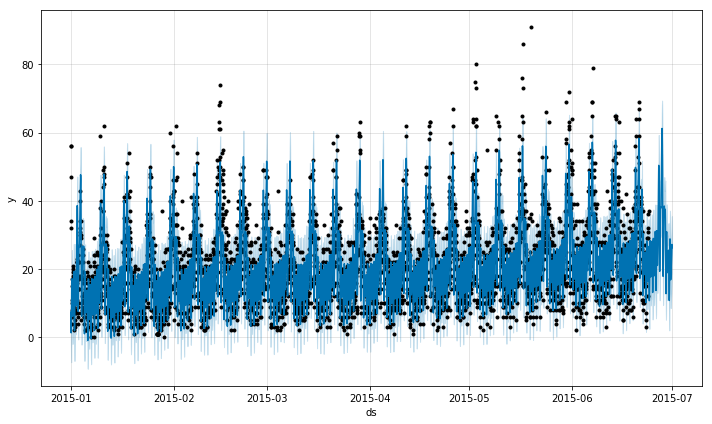

In [33]:
fig1 = m.plot(forecast)

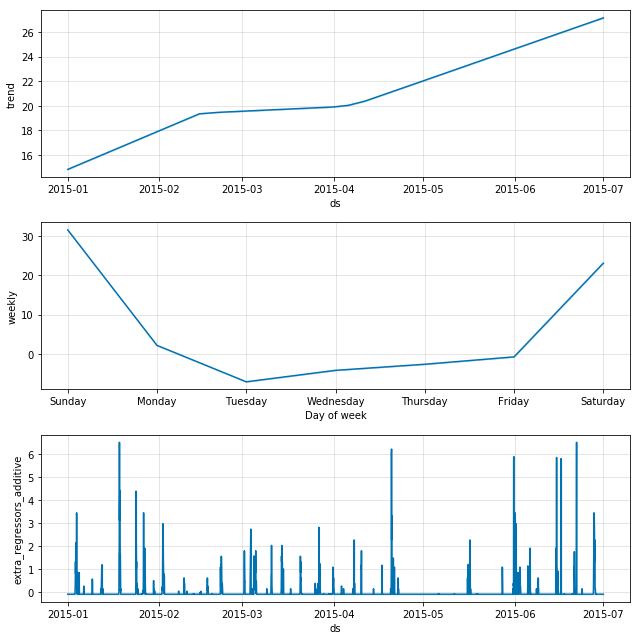

In [34]:
fig2 = m.plot_components(forecast)

### Forecast the demand for all 140 locations using Prophet

In [41]:
def forecast_loc(rides_weather, loc_index, loc_name, regressors=False):
    '''
    regressors should a list of either precip or temp, i.e. ["precip","temp"]
    '''
    
    df = ts_train.iloc[:, [loc_index,-1,-2]].reset_index().rename(columns={"date":"ds",loc_name:"y"})
    m = Prophet(changepoint_prior_scale=0.01,
                yearly_seasonality = False,
                weekly_seasonality = 25,
                daily_seasonality = False
               )
    
    # add regressors if specified
    if regressors:
        for regressor in regressors:
            m.add_regressor(regressor,standardize=True)
    
    m.fit(df)
    
    # Forecast for 1 week
    future = m.make_future_dataframe(periods=(24*7),freq="H")
    # add precip and temp columns in case you want to add these regressors
    future = future.merge(rides_weather.loc[:,["precip","temp"]].reset_index().rename(columns={"date":"ds"}),how="left")
    forecast = m.predict(future)
    y_pred = forecast['yhat'].tail(len(ts_test)).values
    y_actual = ts_test[loc_name].values
    mse = mean_squared_error(y_actual, y_pred)
    rmse = calc_rmse(y_actual,y_pred)
    error = rmse/np.mean(y_actual)
    print('rmse: {}'.format(rmse))
    return {loc_name:{"y_pred":y_pred,"y_actual":y_actual,"mse":mse,"rmse":rmse,"error":error}}

In [42]:
def forecast_all(rides_weather, regressors=[]):
    forecast_dict = {}
    total = len(ts_train.columns[:-2])
    for loc_index, loc_name in enumerate(ts_train.columns[:-2]):
        temp_dict = forecast_loc(rides_weather, loc_index, loc_name, regressors)
        forecast_dict.update(temp_dict)
        print('({}/{})'.format(loc_index+1, total), "finished forecasting for", loc_name, "...")
    return pd.DataFrame(forecast_dict)

In [43]:
forecast_weekly = forecast_all(rides_weather, regressors = ["precip"])
#forecast_noreg = forecast_all(rides_weather)
#forecast_1w_precip = forecast_all(rides_weather, regressors = ["precip"])
#forecast_1w_noreg = forecast_all(rides_weather)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


rmse: 7.545889914866405
(1/140) finished forecasting for Alphabet City ...
rmse: 7.7730271174681596
(2/140) finished forecasting for Astoria ...
rmse: 10.874065178040198
(3/140) finished forecasting for Battery Park City ...
rmse: 3.7825615116831157
(4/140) finished forecasting for Bay Ridge ...
rmse: 1.5739497609288244
(5/140) finished forecasting for Bayside ...
rmse: 6.62787292849723
(6/140) finished forecasting for Bedford ...
rmse: 1.5212991902099269
(7/140) finished forecasting for Belmont ...
rmse: 1.98802474395208
(8/140) finished forecasting for Bensonhurst West ...
rmse: 2.705431009620002
(9/140) finished forecasting for Bloomingdale ...
rmse: 6.609541563023243
(10/140) finished forecasting for Boerum Hill ...
rmse: 2.7006764015748472
(11/140) finished forecasting for Borough Park ...
rmse: 1.8497710037509694
(12/140) finished forecasting for Briarwood/Jamaica Hills ...
rmse: 6.366238717536771
(13/140) finished forecasting for Brooklyn Heights ...
rmse: 1.8260772175748643
(14

rmse: 2.975876926671777
(107/140) finished forecasting for Riverdale/North Riverdale/Fieldston ...
rmse: 4.635393651734772
(108/140) finished forecasting for Seaport ...
rmse: 15.203670120384691
(109/140) finished forecasting for SoHo ...
rmse: 2.0579006803842295
(110/140) finished forecasting for South Ozone Park ...
rmse: 2.186697814558915
(111/140) finished forecasting for Spuyten Duyvil/Kingsbridge ...
rmse: 5.244448800997116
(112/140) finished forecasting for Steinway ...
rmse: 8.078529828289767
(113/140) finished forecasting for Stuy Town/Peter Cooper Village ...
rmse: 5.953162514882145
(114/140) finished forecasting for Stuyvesant Heights ...
rmse: 4.6273694618358565
(115/140) finished forecasting for Sunnyside ...
rmse: 1.857632609274335
(116/140) finished forecasting for Sunset Park East ...
rmse: 3.9595443143369757
(117/140) finished forecasting for Sunset Park West ...
rmse: 13.159639891000044
(118/140) finished forecasting for Sutton Place/Turtle Bay North ...
rmse: 29.5665

In [45]:
#forecast_noreg.to_pickle("forecast_noreg.pkl")
forecast_noreg = pd.read_pickle("forecast_noreg.pkl")
#forecast_precip.to_pickle("forecast_precip.pkl")
forecast_precip = pd.read_pickle("forecast_precip.pkl")
#forecast_1w_noreg.to_pickle("forecast_1w_noreg.pkl")
forecast_1w_noreg = pd.read_pickle("forecast_1w_noreg.pkl")
#forecast_1w_precip.to_pickle("forecast_1w_precip.pkl")
forecast_1w_precip = pd.read_pickle("forecast_1w_precip.pkl")


In [46]:
rmse_forecast_weekly = sqrt(forecast_weekly.iloc[1,:].mean())
rmse_1w_precip = sqrt(forecast_1w_precip.iloc[1,:].mean())
rmse_1w_noreg = sqrt((forecast_1w_noreg.iloc[1,:].mean()))
print("RMSE weekly: {}".format(rmse_forecast_weekly))
print("RMSE no regressor: {}".format(rmse_1w_noreg))
print("RMSE precipitation added: {}".format(rmse_1w_precip))

RMSE weekly: 12.88655515909287
RMSE no regressor: 18.31779720002867
RMSE precipitation added: 17.260439914017663


18.31779720002867

In [31]:
# 
sqrt(forecast_noreg.iloc[1,:].sum())

198.24312108470866

In [29]:
sqrt(forecast_precip.iloc[1,:].sum())

194.63757506858823

In [97]:
sqrt(forecast_1w_precip.iloc[1,:].sum())

204.22827924545115

In [98]:
sqrt(forecast_1w_noreg.iloc[1,:].sum())

216.73909937201674

In [17]:
def rmse(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

In [18]:
ts_test.index

DatetimeIndex(['2015-06-24 00:00:00', '2015-06-24 01:00:00',
               '2015-06-24 02:00:00', '2015-06-24 03:00:00',
               '2015-06-24 04:00:00', '2015-06-24 05:00:00',
               '2015-06-24 06:00:00', '2015-06-24 07:00:00',
               '2015-06-24 08:00:00', '2015-06-24 09:00:00',
               ...
               '2015-06-30 14:00:00', '2015-06-30 15:00:00',
               '2015-06-30 16:00:00', '2015-06-30 17:00:00',
               '2015-06-30 18:00:00', '2015-06-30 19:00:00',
               '2015-06-30 20:00:00', '2015-06-30 21:00:00',
               '2015-06-30 22:00:00', '2015-06-30 23:00:00'],
              dtype='datetime64[ns]', name='date', length=168, freq=None)

RMSE: 2.31
RMSE/mean(daily): 62.23%


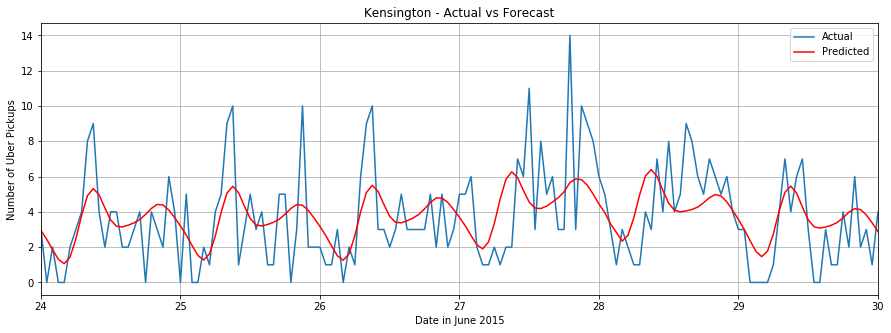

In [50]:
def plot_forecast(actual, pred, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='Number of Uber Pickups', 
                  grid=True, figsize=(10, 5)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(actual.index.date[::24], 
               actual.index.day[::24])
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0)
    plt.grid(True)
location = np.random.choice(forecast_1w_precip.columns)
plt_actual = pd.DataFrame(forecast_1w_precip.loc["y_actual",location], index=ts_test.index)

plot_forecast(plt_actual, forecast_1w_precip.loc["y_pred",location], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date in June 2015', figsize=(15, 5))

print('RMSE: {:.2f}'.format(forecast_1w_precip.loc["rmse",location]))
print('RMSE/mean(daily): {:.2%}'.format(forecast_1w_precip.loc["error",location]))

In [51]:
def plot_forecast(df,loc=False, 
                  xlabel='Date', ylabel='Number of Uber Pickups', 
                  grid=True, figsize=(10, 5)):
    # If location is specified, plot location. otherwise pick a random location
    if loc:
        location = df.columns[loc]
    else:
        location = np.random.choice(df.columns)        
    actual = pd.DataFrame(df.loc["y_actual",location], index=ts_test.index)
    pred = df.loc["y_pred",location]
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(location, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    
#     plt.xticks(actual.index.date[::24], 
#                actual.index.weekday[::24])   
    plt.xticks(actual.index.date[::24], 
           ["Wed","Thurs","Fri","Sat","Sun","Mon","Tues"], fontsize=14)   
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0, fontsize=13)
    plt.grid(True)

    

In [86]:
rides_weather.columns[12:20]

Index(['Brooklyn Heights', 'Brooklyn Navy Yard', 'Brownsville',
       'Bushwick North', 'Bushwick South', 'Canarsie', 'Carroll Gardens',
       'Central Harlem'],
      dtype='object')

In [6]:
plot_forecast(forecast_1w_noreg, loc=12,
              xlabel = 'Last week of June 2015', figsize=(13, 5))

print('RMSE: {:.2f}'.format(forecast_1w_noreg.loc["rmse",location]))
print('RMSE/mean(daily): {:.2%}'.format(forecast_1w_noreg.loc["error",location]))

TypeError: plot_forecast() got an unexpected keyword argument 'loc'

RMSE: 12.19
RMSE/mean(daily): 40.97%


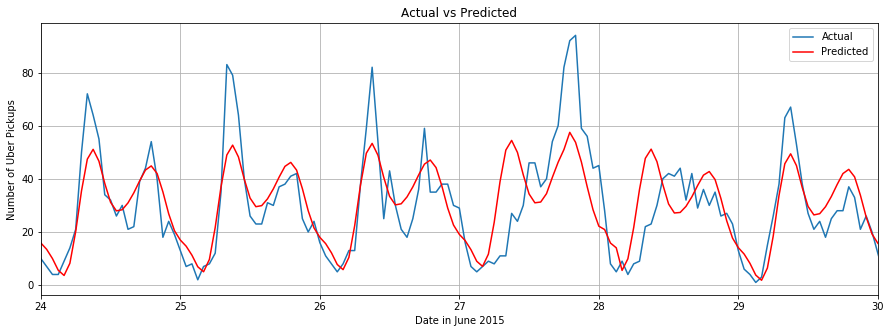

In [24]:
location = np.random.choice(forecast_1w_precip.columns)
plt_actual = pd.DataFrame(forecast_1w_precip.loc["y_actual",location], index=ts_test.index)

plot_forecast(plt_actual, forecast_1w_precip.loc["y_pred",location], 
              xlabel = 'Date in June 2015', figsize=(15, 5))

print('RMSE: {:.2f}'.format(forecast_1w_precip.loc["rmse",location]))
print('RMSE/mean(daily): {:.2%}'.format(forecast_1w_precip.loc["error",location]))

In [16]:
for i, n in enumerate(test.columns):
    print(rmse(test[n]["y_actual"],test[n]["y_pred"]))

10.508367266990971
9.252327414427652
14.20560335689378


In [34]:
rmse(test.iloc[0,1],test.iloc[1,1])


9.252327414427652

## Model Comparison
You will need to run other notebooks first before loading the GRU model here for comparison

In [52]:
GRU_pred = pd.read_csv("prediction_df.csv",index_col=0)

In [53]:
def compare_forecast(prophet, GRU, loc=False, 
                  xlabel='Date', ylabel='Number of Uber Pickups', 
                  grid=True, figsize=(10, 5)):
    # If location is specified, plot location. otherwise pick a random location
    if loc:
        location = prophet.columns[loc]
    else:
        location = np.random.choice(prophet.columns)        
    actual = pd.DataFrame(prophet.loc["y_actual",location], index=ts_test.index)
    prophet_pred = prophet.loc["y_pred",location]
    GRU_pred = GRU[location]
    
    if len(actual) != len(prophet_pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual', c="g")
    plt.plot(actual.index, prophet_pred, label='Prophet', c='b')
    plt.plot(actual.index, GRU_pred, label='GRU', c='r')
    plt.title(location,fontsize=20)
    plt.xlabel("Day of Week (June 24-30)",fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    
#     plt.xticks(actual.index.date[::24], 
#                actual.index.weekday[::24])   
    plt.xticks(actual.index.date[::24], 
           ["Wed","Thurs","Fri","Sat","Sun","Mon","Tues"],fontsize=15)   
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0,fontsize=15)
    plt.grid(True)

    

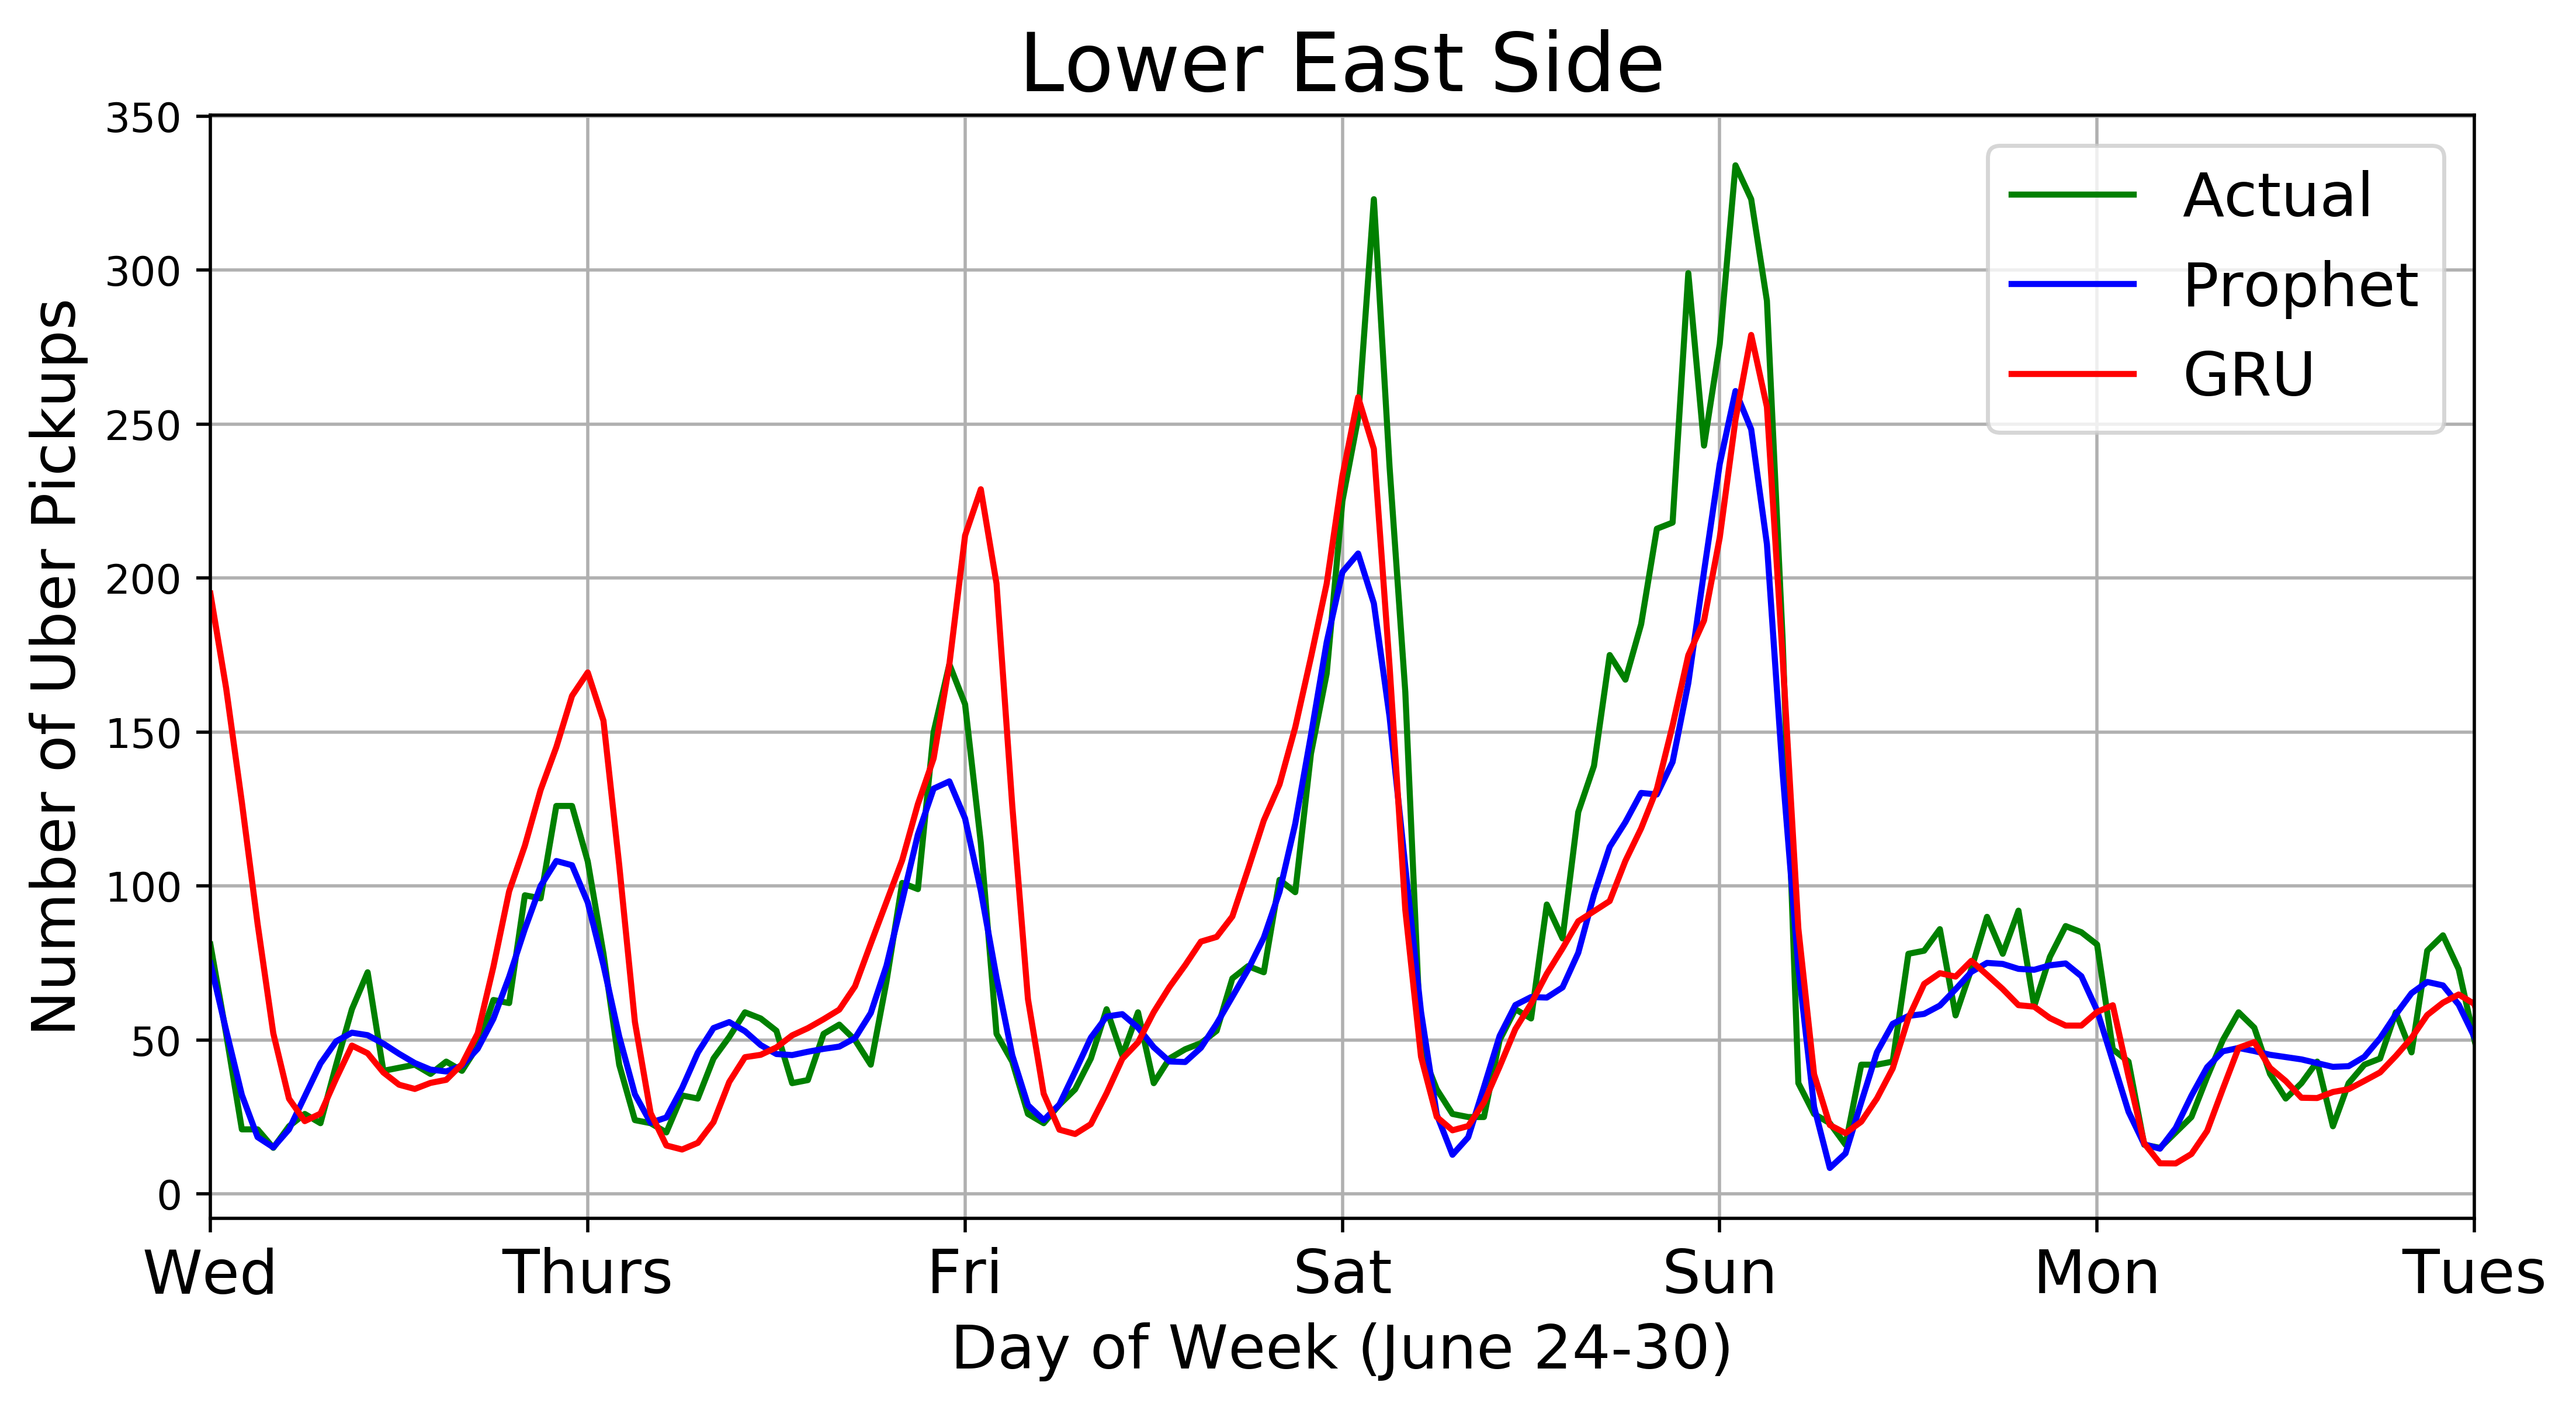

In [54]:
%config InlineBackend.figure_format = 'png'
mpl.rcParams['figure.dpi']= 500
compare_forecast(forecast_weekly, GRU_pred, loc=81)